Beginning by re-establishing previous results based on previous notebook, having gained more familiarity with research

In [77]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import scipy
import matplotlib.pyplot as plt
import pandas as pd

hdul = fits.open("Data/HI-withMA-withPIPE3D.fits")
dataTable = Table(hdul[1].data)
dataTable # to see if it worked, we will print out the table

Aligned_color = 'tab:blue'
MA_color = 'tab:orange'

Total galaxy count: 7277


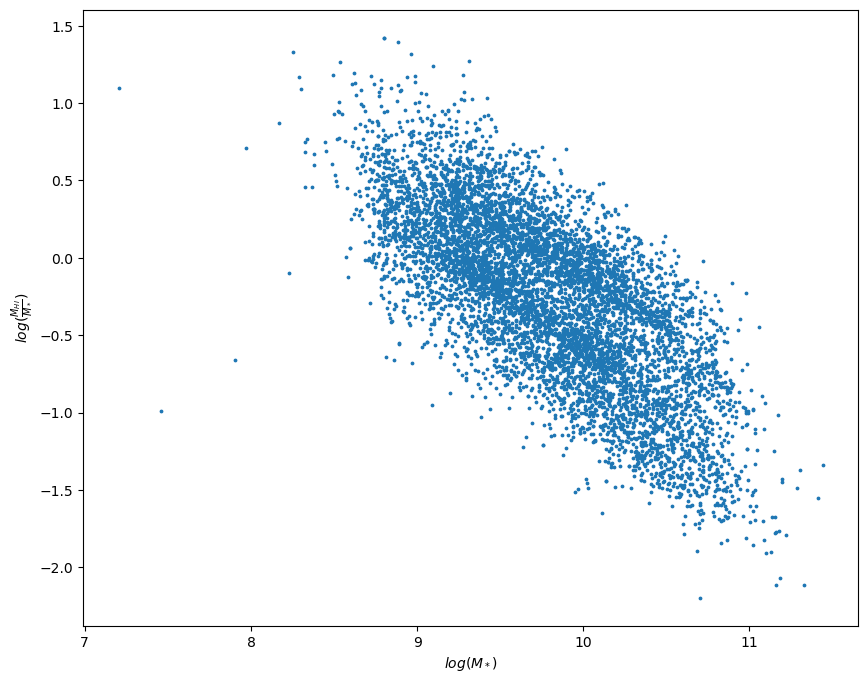

In [67]:
trimmedTable = dataTable[(dataTable['LOGMSTARS'] >= 5) & ((dataTable['LOGHILIM200KMS'] >= 0) | (dataTable['LOGMHI'] >= 0))]
trimmedTable['Best_HI'] = np.empty(len(trimmedTable))
for row in trimmedTable:
    row['Best_HI'] = max(row['LOGMHI'], row['LOGHILIM200KMS'])
print(f'Total galaxy count: {len(trimmedTable)}') # 7278
'''
We are removing any galaxies without measured values of M_HI or M_Stel, which is very important to note.
We include galaxies with no M_HI if they have a reported upper limit for this value.
'''
plt.figure(figsize=(10,8))
plt.scatter(trimmedTable['LOGMSTARS'], trimmedTable['Best_HI'] - trimmedTable['LOGMSTARS'] , s = 3)
plt.xlabel('$log(M_*)$')
plt.ylabel(r'$log(\frac{M_{HI}}{M_*})$') # 'raw' string denoted w/ r before quote to allow for LaTeX formatting
plt.show()

# Important to note that an outlying aligned galaxies has been cropped from the far top left of the plot
# by setting the minimum LOGMSTARS value to 5 instead of 0

We seek to identify which galaxies have misalignent. These are simply those with values for position angles, from Zhou et al. 2022

In [68]:
MA_table = trimmedTable[trimmedTable['ang_stellar'].astype(str) != str(np.nan)]
Aligned_table = trimmedTable[trimmedTable['ang_stellar'].astype(str) == str(np.nan)]

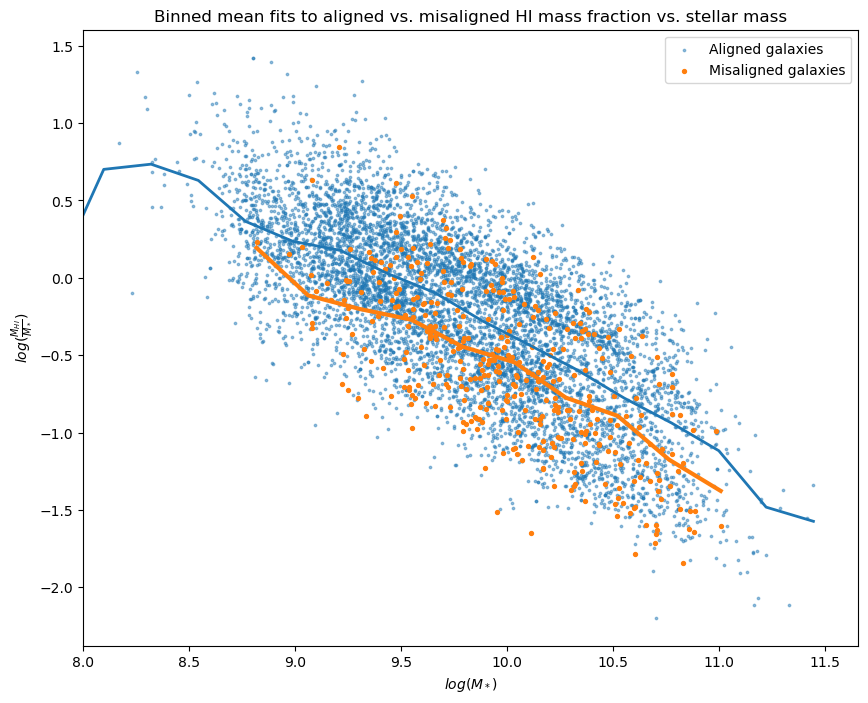

In [82]:
plt.figure(figsize=(10,8))
plt.scatter(Aligned_table['LOGMSTARS'], Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'], s = 3, alpha = .45, label = 'Aligned galaxies', color = Aligned_color)
plt.scatter(MA_table['LOGMSTARS'], MA_table['Best_HI'] - MA_table['LOGMSTARS'], s = 8, label = 'Misaligned galaxies', color = MA_color)
plt.xlabel('$log(M_*)$')
plt.ylabel(r'$log(\frac{M_{HI}}{M_*})$') # 'raw' string denoted w/ r before quote to allow for LaTeX formatting
plt.legend()

alignedBin = scipy.stats.binned_statistic(Aligned_table['LOGMSTARS'], Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'], 'mean', bins=20)
alignedXs = np.linspace(min(Aligned_table['LOGMSTARS']), max(Aligned_table['LOGMSTARS']), 20)
plt.plot(alignedXs, alignedBin[0], lw=2, color = Aligned_color)

MABin = scipy.stats.binned_statistic(MA_table['LOGMSTARS'], MA_table['Best_HI'] - MA_table['LOGMSTARS'], 'mean', bins=10)
MAXs = np.linspace(min(MA_table['LOGMSTARS']), max(MA_table['LOGMSTARS']), 10)
plt.plot(MAXs, MABin[0], lw=3, color = MA_color)

plt.title('Binned mean fits to aligned vs. misaligned HI mass fraction vs. stellar mass')
plt.xlim(left = 8)
plt.show()


We can also plot binned medians, including standard deviation:

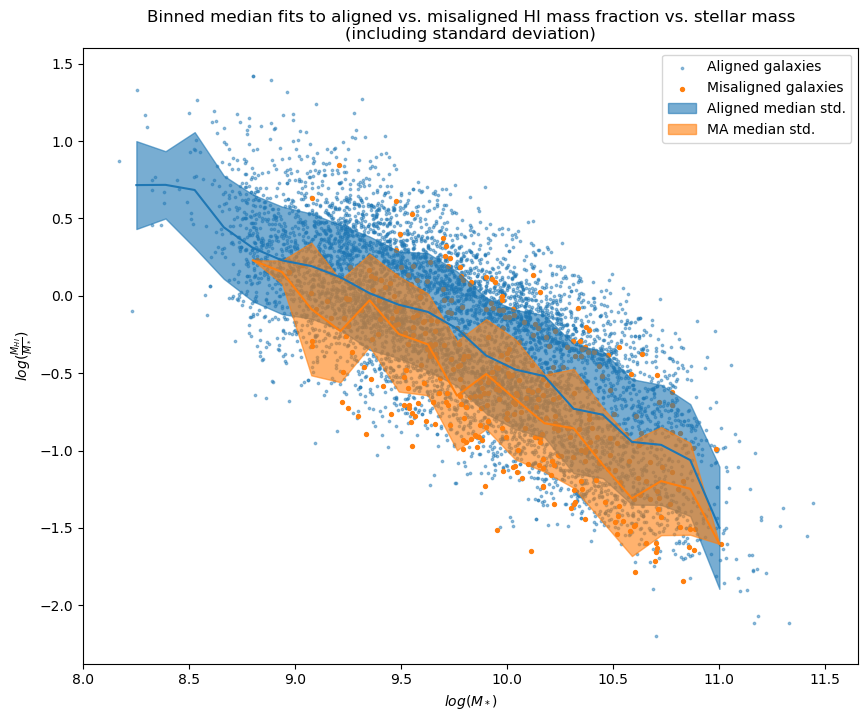

In [109]:
myBins = np.arange(8.25, 11.25, (11.25-8.5)/20)

plt.figure(figsize=(10,8))

plt.scatter(Aligned_table['LOGMSTARS'], Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'], s = 3, alpha = .45, label = 'Aligned galaxies', color = Aligned_color)
plt.scatter(MA_table['LOGMSTARS'], MA_table['Best_HI'] - MA_table['LOGMSTARS'], s = 8, label = 'Misaligned galaxies', color = MA_color)
plt.xlabel('$log(M_*)$')
plt.ylabel(r'$log(\frac{M_{HI}}{M_*})$') # 'raw' string denoted w/ r before quote to allow for LaTeX formatting

Alignedmedians, Alignededgesmedian, Alignednummedian = scipy.stats.binned_statistic(Aligned_table['LOGMSTARS'], Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'],'median',bins=myBins)
Alignedstds, Alignededgesstd, Alignednumstd=scipy.stats.binned_statistic(Aligned_table['LOGMSTARS'], Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'],'std',bins=myBins)
plt.plot(Alignededgesmedian[:-1], Alignedmedians, ls='-', alpha=1, color=Aligned_color)
plt.fill_between(Alignededgesmedian[:-1],Alignedmedians-Alignedstds,Alignedmedians+Alignedstds,alpha=.6, color=Aligned_color, label='Aligned median std.')

MAmedians, MAedgesmedian, MAnummedian = scipy.stats.binned_statistic(MA_table['LOGMSTARS'], MA_table['Best_HI'] - MA_table['LOGMSTARS'], statistic = 'median', bins=myBins)
MAstds,MAedgesstd,MAnumstd=scipy.stats.binned_statistic(MA_table['LOGMSTARS'], MA_table['Best_HI'] - MA_table['LOGMSTARS'], statistic = 'std', bins=myBins)
plt.plot(MAedgesmedian[:-1], MAmedians, ls='-', alpha=1, color=MA_color)
plt.fill_between(MAedgesmedian[:-1],MAmedians-MAstds,MAmedians+MAstds,alpha=.6, color=MA_color, label='MA median std.')

plt.title('Binned median fits to aligned vs. misaligned HI mass fraction vs. stellar mass\n(including standard deviation)')
plt.xlim(left = 8)
plt.legend()
plt.show()

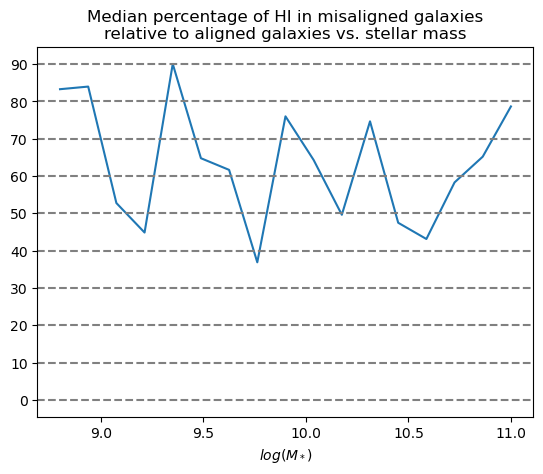

In [110]:
plt.plot(Alignededgesmedian[:-1], 10**(MAmedians - Alignedmedians) * 100, ls='-', alpha=1)
for val in np.arange(0, 100, 10):
    plt.axhline(val, color = 'gray', linestyle = '--')
plt.yticks(np.arange(0, 100, 10))
plt.title('Median percentage of HI in misaligned galaxies\nrelative to aligned galaxies vs. stellar mass')
plt.xlabel('$log(M_*)$')
plt.show()

Misaligned galaxies have, on average, ~40-80% the expected amount of HI compared to their aligned counterparts at similar stellar mass (taking median mass fractions)